In [128]:
import pandas as pd

In [31]:
from numba import jit

In [85]:
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

@jit
def manage(temp, img, axes): # For managing the border cases
    if axes=='y':
        filter_start =  np.array([
            [0.0, 1.0, 0.0],
            [0.0, -1.0, 0.0],
            [0.0, 0.0, 0.0],
        ])
        
        filter_start = np.stack([filter_start] * 3, axis=2)
        temp1_start = convolve(img, filter_start)
        
        
        filter_end =  np.array([
            [0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0],
            [0.0, -1.0, 0.0],
        ])
        
        filter_end = np.stack([filter_end] * 3, axis=2)
        temp1_end = convolve(img, filter_end)
        
        for j in range(img.shape[1]):
            temp[0][j]= temp1_start[0][j]
            temp[img.shape[0]-1][j] = temp1_end[img.shape[0]-1][j]
        
        
    else:
        filter_start =  np.array([
            [0.0, 0.0, 0.0],
            [0.0, -1.0, 1.0],
            [0.0, 0.0, 0.0],
        ])
        
        filter_start = np.stack([filter_start] * 3, axis=2)
        temp1_start = convolve(img, filter_start)
        
        
        filter_end =  np.array([
            [0.0, 0.0, 0.0],
            [-1.0, 1.0, 0.0],
            [0.0, 0.0, 0.0],
        ])
        
        filter_end = np.stack([filter_end] * 3, axis=2)
        temp1_end = convolve(img, filter_end)
        
        for i in range(img.shape[0]):
            temp[i][0]= temp1_start[i][0]
            temp[i][img.shape[1]-1] = temp1_end[i][img.shape[1]-1]
        
     
    return temp

@jit
def get_energy_map(img):
    filter_dy = np.array([
        [0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0],
        [0.0, -1.0, 0.0],
    ])
    

    filter_dy = np.stack([filter_dy] * 3, axis=2)
   
    filter_dx = np.array([
        [0.0, 0.0, 0.0],
        [1.0, 0.0, -1.0],
        [0.0, 0.0, 0.0],
    ])
    
    filter_dx = np.stack([filter_dx] * 3, axis=2)

    img = img.astype('float32')
    temp1 = convolve(img, filter_dy)
    temp1 = manage(temp1,img,'y')
    temp1 = temp1*temp1
    temp2 = convolve(img, filter_dx)
    temp2 = manage(temp2, img,'x')
    temp2 = temp2*temp2
    convolved = temp1+temp2
    energy_map = convolved.sum(axis=2)

    return energy_map

@jit
def minimum_seam(img):
    row, col, dummy = img.shape
    energy_map = get_energy_map(img)
    map_ = energy_map.copy()
    backtrack = np.zeros_like(map_, dtype=np.int)

    for i in range(1, row):
        for j in range(0, col):

            if j == 0:
                idx = np.argmin(map_[i - 1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = map_[i - 1, idx + j]
            else:
                idx = np.argmin(map_[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = map_[i - 1, idx + j - 1]

            map_[i, j] += min_energy

    return map_, backtrack

@jit
def carve_column(img):
    row, col, dummy = img.shape

    map_, backtrack = minimum_seam(img)

    mask = np.ones((row, col), dtype=np.bool)


    j = np.argmin(map_[-1])

    for i in reversed(range(row)):
        mask[i, j] = False
        j = backtrack[i, j]
        
    mask = np.stack([mask] * 3, axis=2)
    img = img[mask].reshape((row, col - 1, 3))

    return img


def vertical(img, scale):
    row, col, dummy = img.shape
    new_col = int(scale * col)

    for i in trange(col - new_col): 
        img = carve_column(img)

    return img


@jit
def horizontal(img, scale):
    img = np.rot90(img, 1, (0, 1))
    img = vertical(img, scale)
    img = np.rot90(img, 3, (0, 1))
    return img

In [49]:
path_addr = "images/path.jpg"
path_img = cv2.imread(path_addr)

##### 60% Horizontal shrinkage of path.jpg

100%|█████████████████████████████████████████| 200/200 [00:09<00:00, 21.88it/s]


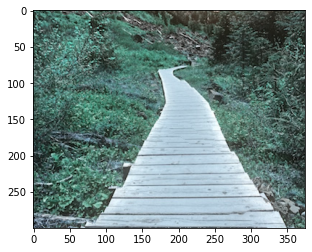

In [60]:
path_img_60=horizontal(path_img,0.6)
plt.imshow(path_img_60)

##### 40% Horizontal shrinkage of path.jpg

100%|█████████████████████████████████████████| 300/300 [00:12<00:00, 24.84it/s]


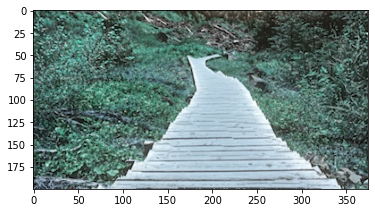

In [61]:
path_img_40=horizontal(path_img,0.4)
plt.imshow(path_img_40)

##### 20% Horizontal shrinkage of path.jpg

100%|█████████████████████████████████████████| 400/400 [00:13<00:00, 29.11it/s]


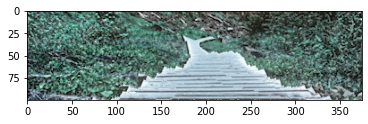

In [62]:
path_img_20=horizontal(path_img,0.2)
plt.imshow(path_img_20)

In [90]:
bd = cv2.imread("images/bangalore-dancers.jpg")

##### 60% vertical shrinkage of bangalore-dancers.jpg

100%|█████████████████████████████████████████| 202/202 [00:09<00:00, 21.50it/s]


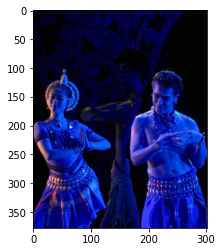

In [91]:
bd_60 = vertical(bd,0.6)
plt.imshow(bd_60)

##### 40% vertical shrinkage of bangalore-dancers.jpg

100%|█████████████████████████████████████████| 303/303 [00:12<00:00, 24.63it/s]


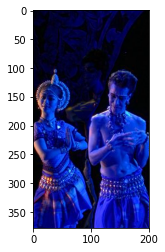

In [92]:
bd_40 = vertical(bd,0.4)
plt.imshow(bd_40)

##### 20% vertical shrinkage of bangalore-dancers.jpg

100%|█████████████████████████████████████████| 404/404 [00:13<00:00, 29.02it/s]


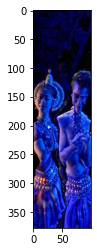

In [93]:
bd_20 = vertical(bd,0.2)
plt.imshow(bd_20)

In [94]:
cat = cv2.imread("images/cat.jpg")

##### 60% vertical shrinkage of cat.jpg 

100%|██████████████████████████████████████████| 60/60 [00:00<00:00, 167.02it/s]


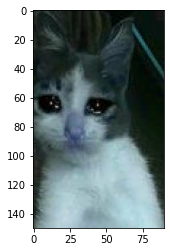

In [96]:
cat_60 = vertical(cat,0.6)
plt.imshow(cat_60)

##### 40% vertical shrinkage of cat.jpg 

100%|██████████████████████████████████████████| 90/90 [00:00<00:00, 185.65it/s]


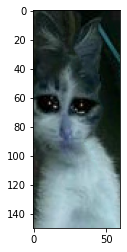

In [97]:
cat_40 = vertical(cat,0.4)
plt.imshow(cat_40)

##### 20% vertical shrinkage of cat.jpg 

100%|████████████████████████████████████████| 120/120 [00:00<00:00, 214.17it/s]


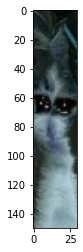

In [98]:
cat_20 = vertical(cat,0.2)
plt.imshow(cat_20)

In [99]:
cb = cv2.imread("images/chhota-bheem.jpg")

##### 60% vertical shrinkage of chhota-bheem.jpg

100%|█████████████████████████████████████████| 768/768 [06:44<00:00,  1.90it/s]


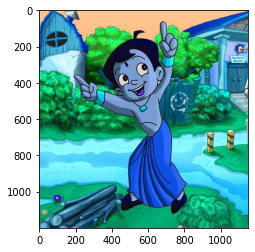

In [100]:
cb_60 = vertical(cb,0.6)
plt.imshow(cb_60)

###### 40% vertical shrinkage of chhota-bheem.jpg

100%|███████████████████████████████████████| 1152/1152 [08:52<00:00,  2.16it/s]


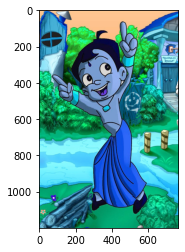

In [101]:
cb_40 = vertical(cb,0.4)
plt.imshow(cb_40)

###### 20% vertical shrinkage of chhota-bheem.jpg

100%|███████████████████████████████████████| 1536/1536 [09:59<00:00,  2.56it/s]


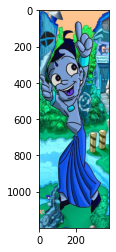

In [102]:
cb_20 = vertical(cb,0.2)
plt.imshow(cb_20)

In [103]:
iiit = cv2.imread("images/iiit.jpg")

##### 60% vertical shrinkage of iiit.jpg

100%|█████████████████████████████████████████| 352/352 [00:26<00:00, 13.49it/s]


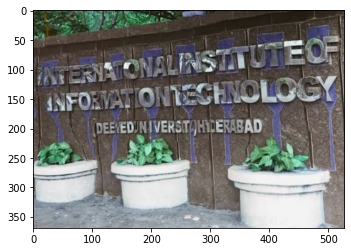

In [104]:
iiit_60 = vertical(iiit,0.6)
plt.imshow(iiit_60)

##### 40% vertical shrinkage of iiit.jpg

100%|█████████████████████████████████████████| 528/528 [00:34<00:00, 15.39it/s]


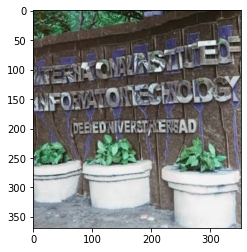

In [105]:
iiit_40 = vertical(iiit,0.4)
plt.imshow(iiit_40)

##### 20% vertical shrinkage of iiit.jpg

100%|█████████████████████████████████████████| 704/704 [00:42<00:00, 16.73it/s]


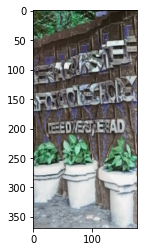

In [106]:
iiit_20 = vertical(iiit,0.2)
plt.imshow(iiit_20)

In [107]:
shadow = cv2.imread("images/shadow.jpg")

##### 60% vertical shrinkage of shadow.jpg

100%|█████████████████████████████████████████| 200/200 [00:07<00:00, 26.21it/s]


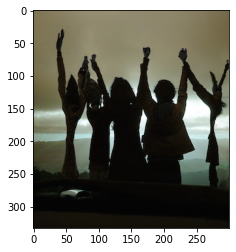

In [108]:
shadow_60 = vertical(shadow,0.6)
plt.imshow(shadow_60)

##### 40% vertical shrinkage of shadow.jpg

100%|█████████████████████████████████████████| 300/300 [00:10<00:00, 29.94it/s]


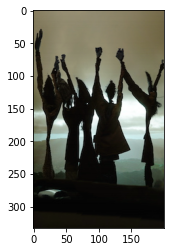

In [109]:
shadow_40 = vertical(shadow,0.4)
plt.imshow(shadow_40)

##### 20% vertical shrinkage of shadow.jpg

100%|█████████████████████████████████████████| 400/400 [00:11<00:00, 34.01it/s]


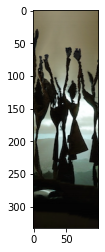

In [110]:
shadow_20 = vertical(shadow,0.2)
plt.imshow(shadow_20)

In [111]:
tanjore = cv2.imread("images/tanjore.jpg")

##### 60% vertical shrinkage of tanjore.jpg

100%|█████████████████████████████████████████| 308/308 [00:27<00:00, 11.36it/s]


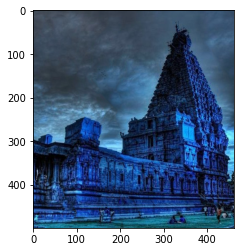

In [112]:
tanjore_60 = vertical(tanjore,0.6)
plt.imshow(tanjore_60)

##### 40% vertical shrinkage of tanjore.jpg

100%|█████████████████████████████████████████| 462/462 [00:35<00:00, 12.87it/s]


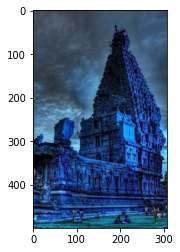

In [113]:
tanjore_40 = vertical(tanjore,0.4)
plt.imshow(tanjore_40)

##### 20% vertical shrinkage of tanjore.jpg

100%|█████████████████████████████████████████| 616/616 [00:40<00:00, 15.12it/s]


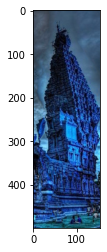

In [114]:
tanjore_20 = vertical(tanjore,0.2)
plt.imshow(tanjore_20)

In [115]:
ts = cv2.imread("images/trafalgar-square.jpg")

##### 60% vertical shrinkage of trafalgar-square.jpg

100%|█████████████████████████████████████████| 144/144 [00:04<00:00, 35.69it/s]


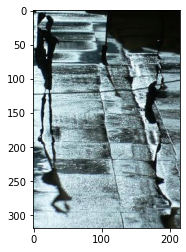

In [116]:
ts_60 = vertical(ts,0.6)
plt.imshow(ts_60)

##### 40% vertical shrinkage of trafalgar-square.jpg

100%|█████████████████████████████████████████| 216/216 [00:05<00:00, 43.20it/s]


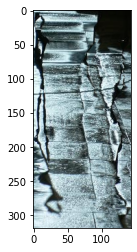

In [117]:
ts_40 = vertical(ts,0.4)
plt.imshow(ts_40)

##### 20% vertical shrinkage of trafalgar-square.jpg

100%|█████████████████████████████████████████| 288/288 [00:05<00:00, 49.07it/s]


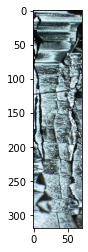

In [118]:
ts_20 = vertical(ts,0.2)
plt.imshow(ts_20)

In [121]:
uluru = cv2.imread("images/uluru.jpg")

##### 60% vertical shrinkage of uluru.jpg

100%|█████████████████████████████████████████| 202/202 [00:08<00:00, 22.61it/s]


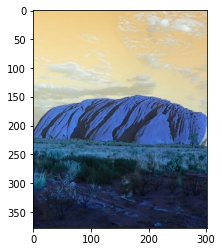

In [122]:
uluru_60 = vertical(uluru,0.6)
plt.imshow(uluru_60)

##### 40% vertical shrinkage of uluru.jpg

100%|█████████████████████████████████████████| 303/303 [00:11<00:00, 26.21it/s]


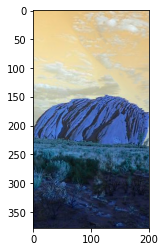

In [123]:
uluru_40 = vertical(uluru,0.4)
plt.imshow(uluru_40)

##### 20% vertical shrinkage of uluru.jpg

100%|█████████████████████████████████████████| 404/404 [00:13<00:00, 30.81it/s]


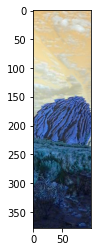

In [124]:
uluru_20 = vertical(uluru,0.2)
plt.imshow(uluru_20)

# Table for time taken

In [133]:
data = {'60%':['9 secs', '0 secs', '6 min 44 secs', '26 secs', '7 secs', '27 secs', '4 secs', '8 secs'],
        '40%':['12 secs', '0 secs', '8 min 52 secs', '34 secs', '10 secs', '35 secs', '5 secs', '11 secs'],
        '20%':['13 secs', '0 secs', '9 min 59 secs', '26 secs', '42 secs', '11 secs', '5 secs', '13 secs'] 
       }

df = pd.DataFrame(data, index =['bangalore-dancers.jpg',
                                'cat.jpg',
                                'chhota-bheem.jpg',
                                'iiit.jpg',
                                'shadow.jpg',
                                'tanjore.jpg',
                                'trafalgar-square.jpg',
                                'uluru.jpg'
                                
                               ])

In [134]:
df

,60%,40%,20%
bangalore-dancers.jpg,9 secs,12 secs,13 secs
cat.jpg,0 secs,0 secs,0 secs
chhota-bheem.jpg,6 min 44 secs,8 min 52 secs,9 min 59 secs
iiit.jpg,26 secs,34 secs,26 secs
shadow.jpg,7 secs,10 secs,42 secs
tanjore.jpg,27 secs,35 secs,11 secs
trafalgar-square.jpg,4 secs,5 secs,5 secs
uluru.jpg,8 secs,11 secs,13 secs


In [135]:
# commented after use


#df.to_csv('result.csv', sep='\t', index=True,header=True)

##### B

The time complexity of seam carving is $O(W*H + W + H)$

For each pixel in a row, there are atmost 3 choices for the pixel in the next row. Thus, total number of seams must be atmost $3^H$. The naive solution for finding energy for each seam would be $O(H*3^H)$

##### C

We cannot decide if the overall energy of the image decreases or increases due to seam carving. Sometimes, while removing seams of lowest energy would give rise to new seams of high energy

There shoudn't be any issue with seam carving done with inverted image. Both should give same output

The order of seam removal is found using  dynamic programming. We will a transport map <b>T</b> that specifies for each desired target image of size $n` \ x \ m` $, the cost of optimal vertical and horizontal seam removal operations. That is, $T(r,c)$ holds the minimal cost need to obtain image of size $(n-r) \ x \ (m-c) $

Base Case :- $T(0,0) = 0$

$T(r,c)$ = min(T(r-1,c)  + cost of removal of seam in image of size $(n-r-1)\ x\ (m-1)$, T(r,c-1)  + cost of removal of seam in image of size $(n-r)\ x \ (m-1-c)$ ) 